# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Install needed libraries

In [1]:
!pip install --upgrade pip

In [2]:
!pip install -U scikit-learn==0.20

In [3]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf
import keras

/opt/conda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
Using TensorFlow backend.


In [6]:
# import sklearn
print(keras.__version__)

2.0.9


In [7]:
import sklearn
print(sklearn.__version__)

0.20.0


# Data Analysis:

## Portfolio

In [8]:
portfolio.head(1)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


In [9]:
portfolio.shape

(10, 6)

In [10]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [11]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [12]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

## Profile

In [13]:
profile.head(1)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN


In [14]:
profile.shape

(17000, 5)

In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [16]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [17]:
profile.duplicated().sum()

0

## Transcript

In [18]:
transcript.head(1)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [19]:
transcript.shape

(306534, 4)

In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [22]:
transcript['value']

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16         {'offer id': '0b1e1539f2cc45b

In [23]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [24]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [25]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# Cleaning

## Portfolio

In [26]:
df_port = portfolio.copy()

In [27]:
dummy = pd.get_dummies(df_port.channels.apply(pd.Series).stack()).sum(level=0)
df_port = pd.concat([df_port, dummy], axis=1)
df_port = df_port.drop(columns='channels')
df_port = df_port.rename(columns={'id':'offer_id'})

## Profile

In [28]:
df_prof = profile.copy()

In [29]:
df_prof['became_member_on'] = pd.to_datetime(df_prof['became_member_on'], format='%Y%m%d')

In [30]:
df_prof = df_prof.rename(columns={'id':'customer_id'})

## Transcript

In [31]:
df_t = transcript.copy()

In [32]:
df_t = df_t.rename(columns={'person':'customer_id'})

In [33]:
df_t['event'] = df_t['event'].str.replace(' ', '-')

In [34]:
df_t['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [35]:
dummy = pd.get_dummies(df_t['event'])
df_t = pd.concat([df_t, dummy], axis=1 )

In [36]:
df_t['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df_t.value]
df_t['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df_t.value]

In [37]:
df_t = df_t.drop(columns='value')

# Merging

In [38]:
df_merge = pd.merge(df_t, df_prof, on='customer_id')

In [39]:
df_merge = pd.merge(df_merge, df_port, on='offer_id', how='left')

### Fixed the Offer_ids

In [40]:
offer_id = df_merge['offer_id'].unique()
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
df_merge['offer_id'] = df_merge['offer_id'].map(offer_dict)
df_merge['offer_id'] = df_merge['offer_id'].replace(1, np.nan)

### Fixed even_id

In [41]:
event_ids = df_merge['event'].unique()
event_dict = pd.Series(event_ids).to_dict()
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
df_merge['event_id'] = df_merge['event'].map(event_dict)

## Final Prep and Saving

In [42]:
df_merge.shape

(306534, 22)

In [43]:
df_merge.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [44]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 22 columns):
event               306534 non-null object
customer_id         306534 non-null object
time                306534 non-null int64
offer-completed     306534 non-null uint8
offer-received      306534 non-null uint8
offer-viewed        306534 non-null uint8
transaction         306534 non-null uint8
offer_id            167581 non-null float64
amount              138953 non-null float64
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
email               167581 non-null float64
mobile              167581 non-null float64
social              167581 non-null float64
web               

In [45]:
df_merge.to_csv('data/data.csv', index=False)

In [46]:
data = pd.read_csv('data/data.csv')

In [47]:
data.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,income,difficulty,duration,offer_type,reward,email,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


# Data Exploration and Visualization :

In [48]:
data.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

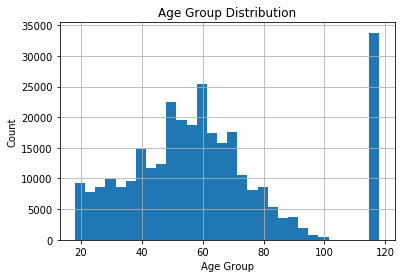

In [49]:
data.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

In [50]:
data.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

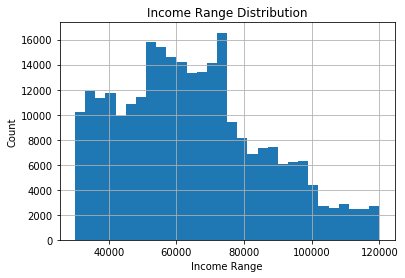

In [51]:
data.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

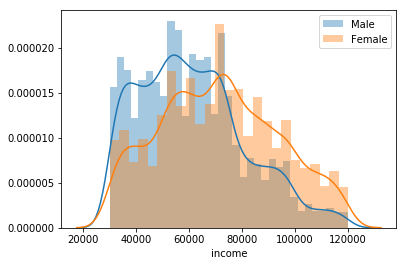

In [52]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

In [53]:
data.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [54]:
male_proportion  = data.gender.value_counts()[0] / data.shape[0]*100
female_proportion = data.gender.value_counts()[1] / data.shape[0]*100
others_proportion = data.gender.value_counts()[2] / data.shape[0]*100

male_proportion ,female_proportion ,others_proportion

(50.790450651477492, 36.896722712651773, 1.2954517280301696)

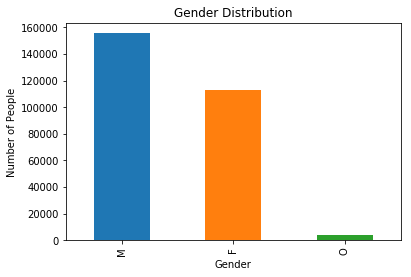

In [55]:
ax = data.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

In [56]:
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed

(discount         30543
 bogo             30499
 informational    15235
 Name: offer_type, dtype: int64, bogo             25449
 discount         21445
 informational    10831
 Name: offer_type, dtype: int64, discount    17910
 bogo        15669
 Name: offer_type, dtype: int64)

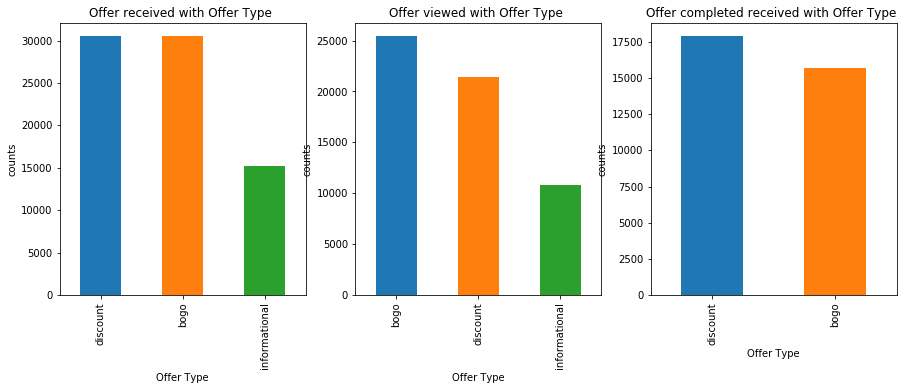

In [57]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

In [58]:
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()

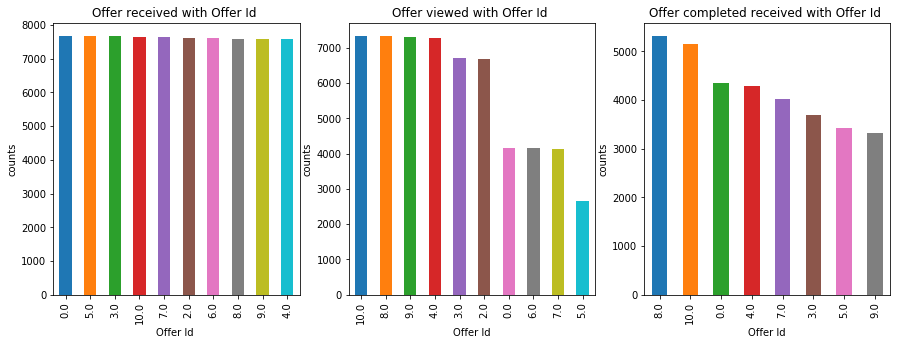

In [59]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

In [60]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count()

customer_id
0009655768c64bdeb2e877511632db8f     3
00116118485d4dfda04fdbaba9a87b5c     4
0011e0d4e6b944f998e987f904e8c1e5     3
0020c2b971eb4e9188eac86d93036a77     4
0020ccbbb6d84e358d3414a3ff76cffd     6
004b041fbfe44859945daa2c7f79ee64     3
004c5799adbf42868b9cff0396190900     8
005500a7188546ff8a767329a2f7c76a     8
0056df74b63b4298809f0b375a304cf4     3
0063def0f9c14bc4805322a488839b32     4
00715b6e55c3431cb56ff7307eb19675     5
0082fd87c18f45f2be70dbcbb0fb8aad     5
00840a2ca5d2408e982d56544dc14ffd     2
00857b24b13f4fe0ad17b605f00357f5     7
008d7088107b468893889da0ede0df5c     6
0091d2b6a5ea4defaa8393e4e816db60    11
0092a132ead946ceb30d11a1ed513d20     6
0099bf30e4cb4265875266eb3eb25eab     2
009d10c2c38a4fd795a7bc6ddbbddb78     2
00a794f62b9a48beb58f8f6c02c2f1a6     5
00ad4c2cace94f67a6354ec90d6c6f45     4
00ae03011f9f49b8a4b3e6d416678b0b     5
00aee28bbb3848dd8a31f0c91dc267dd     4
00b18b535d6d4f779dea4dc9ac451478     2
00b3400e4ff64ee68ce9ada1d0c222f0     2
00b3c376db2a4

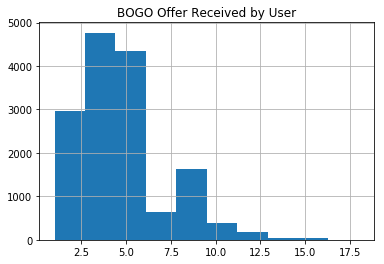

In [61]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count().hist();
plt.title('BOGO Offer Received by User');

In [62]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count()

customer_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
00426fe3ffde4c6b9cb9ad6d077a13ea    2
004b041fbfe44859945daa2c7f79ee64    1
0056df74b63b4298809f0b375a304cf4    2
0063def0f9c14bc4805322a488839b32    2
0069a50874d846438e58acff5e594725    1
00715b6e55c3431cb56ff7307eb19675    1
0082fd87c18f45f2be70dbcbb0fb8aad    6
00840a2ca5d2408e982d56544dc14ffd    1
008d7088107b468893889da0ede0df5c    4
0092a132ead946ceb30d11a1ed513d20    2
00a794f62b9a48beb58f8f6c02c2f1a6    6
00ad4c2cace94f67a6354ec90d6c6f45    4
00ae03011f9f49b8a4b3e6d416678b0b    2
00b18b535d6d4f779dea4dc9ac451478    2
00b3400e4ff64ee68ce9ada1d0c222f0    3
00bbce6533f44ddeaf4dd32bcab55441    2
00c5a385c71a4d3db5e9b4e31e430943    2
00c6035df45840038a72766c6d27a0db    2
00c91f31f5f74e769fa7a359b63e1a9f    3
00d6dc87be4146ceb47fcd4baaaf6477    1
00d791e20c564add8056498e40eb56cc    2


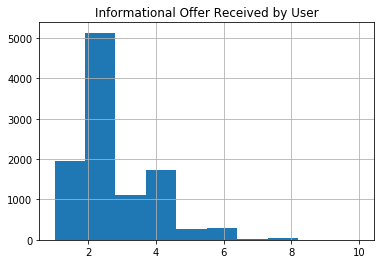

In [63]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count().hist();
plt.title('Informational Offer Received by User');

In [64]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count()

customer_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
00426fe3ffde4c6b9cb9ad6d077a13ea     6
004b041fbfe44859945daa2c7f79ee64     3
004c5799adbf42868b9cff0396190900     6
005500a7188546ff8a767329a2f7c76a     1
0056df74b63b4298809f0b375a304cf4     5
0063def0f9c14bc4805322a488839b32     4
0069a50874d846438e58acff5e594725     5
00715b6e55c3431cb56ff7307eb19675     8
00840a2ca5d2408e982d56544dc14ffd     8
00857b24b13f4fe0ad17b605f00357f5     1
008d7088107b468893889da0ede0df5c     1
0091d2b6a5ea4defaa8393e4e816db60     3
0092a132ead946ceb30d11a1ed513d20     4
0099bf30e4cb4265875266eb3eb25eab     8
009d10c2c38a4fd795a7bc6ddbbddb78     8
00ad4c2cace94f67a6354ec90d6c6f45     2
00ae03011f9f49b8a4b3e6d416678b0b     8
00aee28bbb3848dd8a31f0c91dc267dd     1
00b18b535d6d4f779dea4dc9ac451478     9
00b3400e4ff64ee68ce9ada1d0c222f0     5
00b3c376db2a4

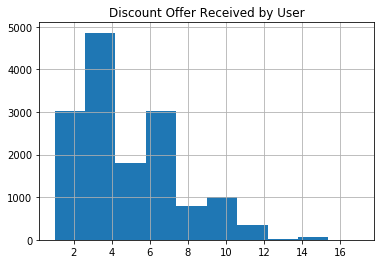

In [65]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count().hist();
plt.title('Discount Offer Received by User');

# Modeling

In [66]:
X = data.drop(['customer_id', 'event_id' , 'event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed', 'transaction'], axis=1)
Y = data['event_id']

X.shape , Y.shape

((306534, 14), (306534,))

In [67]:
X.head()

,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0,0.0,NaN,75,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,6,0.0,NaN,75,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,132,NaN,19.89,75,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0.0,NaN,75,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,144,NaN,17.78,75,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
X.email = [0. if np.isnan(x) else x for x in X.email]

In [69]:
X.email.unique()

array([ 1.,  0.])

In [70]:
column_nan = X.columns[X.isna().any()].tolist()
num_ofent_list = []
num_avg_list = ['amount','income']
cat_list = []
for col in column_nan:
    print(f'column {col}: {X[col].dtype}')
    if X[col].dtype == 'object':
        cat_list.append(col)
    elif X[col].dtype == 'float64' and col not in num_avg_list:
        num_ofent_list.append(col)
cat_list

column offer_id: float64
column amount: float64
column gender: object
column income: float64
column difficulty: float64
column duration: float64
column offer_type: object
column reward: float64
column mobile: float64
column social: float64
column web: float64


['gender', 'offer_type']

In [71]:
often_imput = num_ofent_list + cat_list
often_imput

['offer_id',
 'difficulty',
 'duration',
 'reward',
 'mobile',
 'social',
 'web',
 'gender',
 'offer_type']

In [72]:
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[ ('num', numerical_transformer, num_avg_list),
                    ('cat', categorical_transformer, num_ofent_list)])

### OneHot Encoding

In [73]:
X = pd.get_dummies(data=X, columns=['gender', 'offer_type'])

## Feature Scaling :

In [74]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214573, 18), (91961, 18), (214573,), (91961,))

In [75]:
num_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
for col in num_avg_list:
    X_train[col] = num_imp.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = num_imp.fit_transform(X_test[col].values.reshape(-1, 1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [76]:
cat_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in num_ofent_list:
    X_train[col] = cat_imp.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = cat_imp.fit_transform(X_test[col].values.reshape(-1, 1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [77]:
std = StandardScaler()
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
# X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [78]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
# X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [79]:
X_train.shape, X_test.shape

((214573, 18), (91961, 18))

In [80]:
X_train_keras = X_train.values
X_test_keras = X_test.values
y_train_keras = y_train.values
y_test_keras = y_test.values

# Build Model

## Logistic Regression Classifier / Base Model

In [81]:
# instantiate a logistic regression classifier object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# fit train data to the model
lr_clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', lr_clf) ])
lr_clf_pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0), ['amount', 'income']), ('cat', Pipeline(m...alty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [82]:
preds_lr = lr_clf_pipeline.predict(X_test)

# Evaluate the model
score = accuracy_score(y_test, preds_lr)
print('Accuracy:', score)

Accuracy: 0.699938017203


In [83]:
print(classification_report(y_test, preds_lr, labels=[0,1, 2, 3]))

              precision    recall  f1-score   support

           0       0.46      0.94      0.62     23051
           1       0.34      0.07      0.12     17315
           2       1.00      1.00      1.00     41412
           3       0.34      0.00      0.01     10183

   micro avg       0.70      0.70      0.70     91961
   macro avg       0.54      0.50      0.44     91961
weighted avg       0.67      0.70      0.63     91961



## Random Forest Model

In [84]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# fit train data to the classifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_clf) ])
rf_pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0), ['amount', 'income']), ('cat', Pipeline(m...mators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [85]:
# Preprocessing of validation data, get predictions
preds_rf = rf_pipeline.predict(X_test)

# Evaluate the model
score = accuracy_score(y_test, preds_rf)
print('Accuracy:', score)

Accuracy: 0.583725709812


In [86]:
print(classification_report(y_test, preds_rf, labels=[0,1, 2, 3]))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52     23051
           1       0.37      0.03      0.05     17315
           2       0.61      1.00      0.76     41412
           3       0.30      0.00      0.00     10183

   micro avg       0.58      0.58      0.58     91961
   macro avg       0.45      0.38      0.33     91961
weighted avg       0.51      0.58      0.48     91961



## Artifitial Neural Networks

In [87]:
ann = keras.models.Sequential()

In [88]:
input_shape = (X_train_keras.shape[1],)
ann.add(keras.layers.Dense(6,input_shape=input_shape, activation='relu'))

In [89]:
ann.add(keras.layers.Dense(6, activation='relu'))
ann.add(keras.layers.Dense(6, activation='relu'))
ann.add(keras.layers.Dense(4, activation = 'softmax'))

In [90]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [91]:
ann_history = ann.fit(X_train_keras, y_train_keras, validation_data=(X_test_keras, y_test_keras), epochs=15, batch_size=100)

Train on 214573 samples, validate on 91961 samples
Epoch 1/15
214573/214573 [==============================] - 3s 16us/step - loss: 0.8767 - acc: 0.6100 - val_loss: 0.5653 - val_acc: 0.7132
Epoch 2/15
214573/214573 [==============================] - 3s 16us/step - loss: 0.5483 - acc: 0.7158 - val_loss: 0.5428 - val_acc: 0.7190
Epoch 3/15
214573/214573 [==============================] - 3s 16us/step - loss: 0.5323 - acc: 0.7237 - val_loss: 0.5289 - val_acc: 0.7233
Epoch 4/15
214573/214573 [==============================] - 3s 15us/step - loss: 0.5205 - acc: 0.7259 - val_loss: 0.5237 - val_acc: 0.7212
Epoch 5/15
214573/214573 [==============================] - 3s 16us/step - loss: 0.5166 - acc: 0.7253 - val_loss: 0.5206 - val_acc: 0.7280
Epoch 6/15
214573/214573 [==============================] - 3s 16us/step - loss: 0.5133 - acc: 0.7270 - val_loss: 0.5132 - val_acc: 0.7266
Epoch 7/15
214573/214573 [==============================] - 3s 16us/step - loss: 0.5140 - acc: 0.7267 - val_loss: 0

In [92]:
# Summary of our model
ann.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 28        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [93]:
ann_history.params

{'batch_size': 100,
 'epochs': 15,
 'steps': None,
 'samples': 214573,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

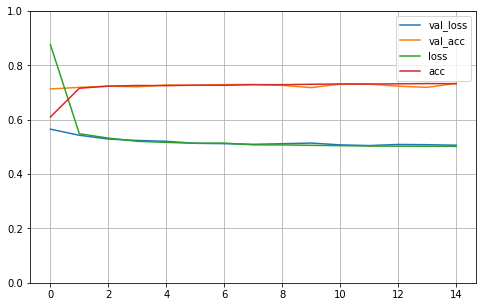

In [94]:
pd.DataFrame(ann_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [95]:
ann.evaluate(X_test_keras , y_test_keras)

91961/91961 [==============================] - 2s 18us/step


[0.50622982494800828, 0.73376757538392134]

In [96]:
y_pred_ann = ann.predict_classes(X_test_keras)

91961/91961 [==============================] - 1s 12us/step


In [97]:
print(classification_report(y_test_keras, y_pred_ann, labels=[0,1, 2, 3]))

              precision    recall  f1-score   support

           0       0.51      0.94      0.66     23051
           1       0.70      0.12      0.21     17315
           2       1.00      1.00      1.00     41412
           3       0.44      0.22      0.30     10183

   micro avg       0.73      0.73      0.73     91961
   macro avg       0.66      0.57      0.54     91961
weighted avg       0.76      0.73      0.69     91961



# Conclusion

The problem that I chose to solve was to build a model that classifies which promotion suits better to each customer.

My strategy for solving this problem has mainly two steps. First, I combined offer portfolio, customer profile, and transaction data. 

Second, I built three models and assessed the accuracyof them. 

Third, I compared the performance of logistic regression and random forest models. This analysis suggests that a random forest model has the best training data accuracy. The analysis also suggests that the random forest model has a training data accuracy of 0.611. However, when compared with the neural network model that accuracy is low. We can see that the ann model has an accuracy of 0.733.

Furthermore, initially, it seemed like we had a lot of data to work on, but once NaN values and duplicate columns were dropped and the data were combined into one single dataset, it felt as though the models might have benefited from more data. With more data, the classification models may have been able to produce better accuracy.

Additionally, better predictions may have been deducted if there were more customer metrics. For this analysis, I feel we had limited information about the customer available to us — just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results.